In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from model_training import DoodleDataset, RealDataset

In [2]:
doodle_val_set = DoodleDataset(train=False)
real_val_set = RealDataset(train=False)

Loaded dataset at 'dataset/quickdraw/quickdraw.npy'.
Loaded dataset at 'dataset/sketchy/sketchy_doodle.npy'.
Loaded dataset at 'dataset/tuberlin/tuberlin.npy'.
Loaded dataset at 'dataset/google_images/google_doodles.npy'.
Loaded dataset at 'dataset/cifar/cifar.npy'.
Loaded dataset at 'dataset/sketchy/sketchy_real.npy'.
Loaded dataset at 'dataset/google_images/google_real.npy'.


In [3]:
def convbn(in_channels, out_channels, kernel_size, stride, padding, bias):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

class CNN(nn.Module):
    CHANNELS = [64, 128, 192, 256, 512]
    POOL = (1, 1)
    def __init__(self, n_channels, n_classes=9, dropout=0):
        super(CNN, self).__init__()
        layer1 = convbn(n_channels, self.CHANNELS[1], kernel_size=3, stride=2, padding=1, bias=True)
        layer2 = convbn(self.CHANNELS[1], self.CHANNELS[2], kernel_size=3, stride=2, padding=1, bias=True)
        layer3 = convbn(self.CHANNELS[2], self.CHANNELS[3], kernel_size=3, stride=2, padding=1, bias=True)
        layer4 = convbn(self.CHANNELS[3], self.CHANNELS[4], kernel_size=3, stride=2, padding=1, bias=True)
        pool = nn.AdaptiveAvgPool2d(self.POOL)
        self.layers = nn.Sequential(layer1, layer2, layer3, layer4, pool)
        self.nn = nn.Linear(self.POOL[0] * self.POOL[1] * self.CHANNELS[4], n_classes)
        self.dropout = nn.Dropout(p=dropout)
    def forward(self, x, return_feats=False):
        feats = self.layers(x).flatten(1)
        x = self.nn(self.dropout(feats))
        if return_feats:
            return x, feats
        return x

In [4]:
x = torch.rand(100, 3, 64, 64)
y = CNN(3)(x)
print (y.shape)

torch.Size([100, 9])


In [5]:
doodle_model = CNN(1, 9)
real_model = CNN(3, 9)

In [6]:
from engine import Engine
engine = Engine(real_val_set, doodle_model, real_model)

building database... [0 / 11141]
building database... [1000 / 11141]
building database... [2000 / 11141]
building database... [3000 / 11141]
building database... [4000 / 11141]
building database... [5000 / 11141]
building database... [6000 / 11141]
building database... [7000 / 11141]
building database... [8000 / 11141]
building database... [9000 / 11141]
building database... [10000 / 11141]
building database... [11000 / 11141]
Engine ready. Database size: 11141


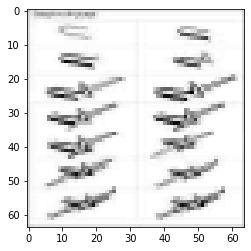

In [31]:
import matplotlib.pyplot as plt

doodle, doodle_label = doodle_val_set[11]    # a random doodle sample
plt.imshow(doodle.reshape(64,64), cmap="gray")
plt.show()

In [9]:
print(doodle.shape)

torch.Size([1, 64, 64])


In [25]:
out_samples = engine.query(doodle, topk=10)
print (out_samples[3][0])

shape:  torch.Size([1, 64, 64])
[[[  8  85 163]
  [  5  75 153]
  [  9  69 150]
  ...
  [ 35  35  44]
  [ 35  33  41]
  [ 33  31  39]]

 [[ 59 107 208]
  [ 47 106 200]
  [ 29  98 185]
  ...
  [ 36  33  40]
  [ 35  32  38]
  [ 34  31  37]]

 [[ 68 109 214]
  [ 71 113 217]
  [ 72 115 219]
  ...
  [ 39  34  39]
  [ 37  33  36]
  [ 29  27  31]]

 ...

 [[ 54 119 185]
  [ 58 121 188]
  [ 55 120 188]
  ...
  [ 64  73  92]
  [ 67  75  98]
  [ 64  72  93]]

 [[ 31  70 126]
  [ 47 104 170]
  [ 45 113 182]
  ...
  [ 68  76  97]
  [ 66  74  97]
  [ 62  72  93]]

 [[ 26  91 155]
  [ 36 103 171]
  [ 41 110 179]
  ...
  [ 65  75  96]
  [ 64  72  94]
  [ 61  72  93]]]


doodle label:  1
3
8
8
2
2
8
3
8
8
3


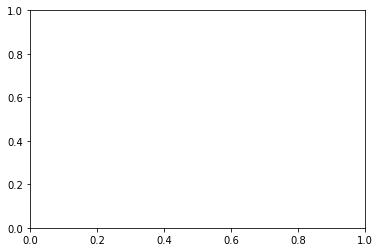

In [14]:
# check the labels of the returned samples, which ideally should be the same as the doodle_label
print ("doodle label: ", doodle_label)
plt.subplot()
for pic, label in out_samples:
    print (label)